# Optical Flow

Optical flow tracks objects by looking at where the *same* points have moved from one image frame to the next. Let's load in a few example frames of a pacman-like face moving to the right and down and see how optical flow finds **motion vectors** that describe the motion of the face!

As usual, let's first import our resources and read in the images.

In [29]:
from typing import Dict, Any
import numpy as np
import matplotlib.image as mpimg  # for reading in images
import matplotlib.pyplot as plt
import cv2  # computer vision library

%matplotlib inline

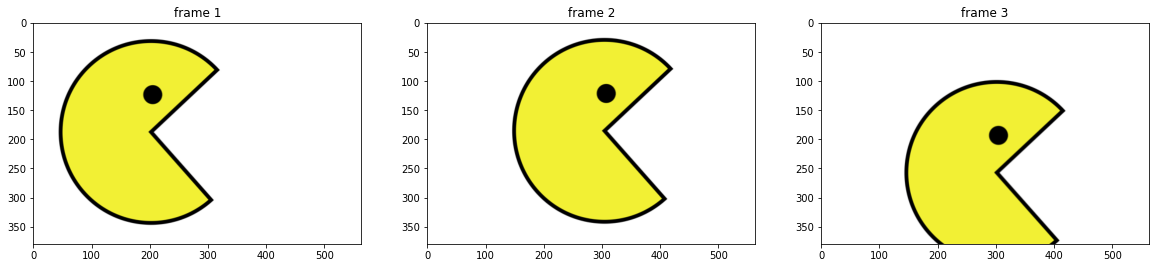

In [30]:

# Read in the image frames
frame_1: np.ndarray = cv2.imread(filename='images/pacman_1.png')
frame_2: np.ndarray = cv2.imread(filename='images/pacman_2.png')
frame_3: np.ndarray = cv2.imread(filename='images/pacman_3.png')

# convert to RGB
frame_1 = cv2.cvtColor(src=frame_1, code=cv2.COLOR_BGR2RGB)
frame_2 = cv2.cvtColor(src=frame_2, code=cv2.COLOR_BGR2RGB)
frame_3 = cv2.cvtColor(src=frame_3, code=cv2.COLOR_BGR2RGB)


# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('frame 1')
ax1.imshow(frame_1)
ax2.set_title('frame 2')
ax2.imshow(frame_2)
ax3.set_title('frame 3')
ax3.imshow(frame_3);


## Finding Points to Track

Befor optical flow can work, we have to give it a set of *keypoints* to track between two image frames!

In the below example, we use a **Shi-Tomasi corner detector**, which uses the same process as a Harris corner detector to find patterns of intensity that make up a "corner" in an image, only it adds an additional parameter that helps select the most prominent corners. You can read more about this detection algorithm in [the documentation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html). The function [goodFeaturesToTrack](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) helps in this case to implement the Shi-Tomasi Corner Detection. Following are some of he settings that we'd pass in this function.

- `maxCorners`: Maximum number of corners to return. If there are more corners than are found, the strongest of them is returned. maxCorners <= 0 implies that no limit on the maximum is set and all detected corners are returned.
- `qualityLevel`: Parameter characterizing the minimal accepted quality of image corners. The parameter value is multiplied by the best corner quality measure, which is the minimal eigenvalue (see [cornerMinEigenVal](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga3dbce297c1feb859ee36707e1003e0a8) ) or the Harris function response (see [cornerHarris](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345) ). The corners with the quality measure less than the product are rejected. For example, if the best corner has the quality measure = 1500, and the qualityLevel=0.01 , then all the corners with the quality measure less than 15 are rejected.
- `minDistance`: Minimum possible Euclidean distance between the returned corners.
- `blockSize`: Size of an average block for computing a derivative covariance matrix over each pixel neighborhood.

Alternatively, you could choose to use Harris or even ORB to find feature points. I just found that this works well.

**You sould see that the detected points appear at the corners of the face.**

[[[318.  82.]]

 [[308. 304.]]

 [[208. 188.]]

 [[309.  81.]]

 [[299. 304.]]

 [[199. 188.]]]


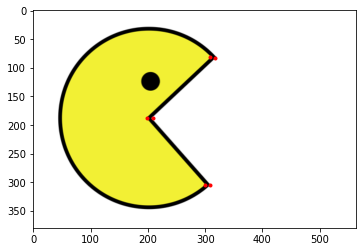

In [38]:
# parameters for ShiTomasi corner detection
feature_params: Dict[str, Any] = {
    'maxCorners': 10,
    'qualityLevel': 0.2,
    'minDistance': 5,
    'blockSize': 5 
}


# convert all frames to grayscale
gray_1: np.ndarray = cv2.cvtColor(src=frame_1, code=cv2.COLOR_RGB2GRAY)
gray_2: np.ndarray = cv2.cvtColor(src=frame_2, code=cv2.COLOR_RGB2GRAY)
gray_3: np.ndarray = cv2.cvtColor(src=frame_3, code=cv2.COLOR_RGB2GRAY)


# Take first frame and find corner points in it
pts_1: np.ndarray = cv2.goodFeaturesToTrack(image=gray_1, mask = None, **feature_params)

# display the detected points
plt.imshow(frame_1)

for p in pts_1:
    # plot x and y detected points
    plt.plot(p[0][0], p[0][1], 'r.', markersize=6)

# print out the x-y locations of the detected points
print(pts_1)

One small detail not to skip here, is that the border of the image is thick. Hence for each corner it detects an inner and an outer corner points.

## Perform Optical Flow

Once we've detected keypoints on our initial image of interest, we can calculate the optical flow between this image frame (frame 1) and the next frame (frame 2), using OpenCV's `calcOpticalFlowPyrLK` which is [documented, here](https://docs.opencv.org/trunk/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). It takes in an initial image frame, the next image, and the first set of points, and it returns the detected points in the next frame and a value that indicates how good matches are between points from one frame to the next. In this implementation we'd use the following optional settings with the function.

- `winSize`: Size of the search window at each pyramid level.
- `maxLevel`: A 0-based maximal pyramid level number; if set to 0, pyramids are not used (single level), if set to 1, two levels are used, and so on; if pyramids are passed to input then algorithm will use as many levels as pyramids have but no more than maxLevel.
- `criteria`: Parameter, specifying the termination criteria of the iterative search algorithm (after the specified maximum number of iterations criteria.maxCount or when the search window moves by less than criteria.epsilon.

So this function makes use of an iterative algorithm based on provided settings.

In [41]:
# parameters for lucas kanade optical flow
lk_params: Dict[str, Any] = {
    'winSize': (5,5),
    'maxLevel': 2,
    'criteria': (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
}


# calculate optical flow between first and second frame
pts_2, match, err = cv2.calcOpticalFlowPyrLK(prevImg=gray_1, nextImg=gray_2, prevPts=pts_1, nextPts=None, **lk_params)

# Select good matching points between the two image frames
good_new: np.ndarray = pts_2[match==1]
good_old: np.ndarray = pts_1[match==1]

Next, let's display the resulting motion vectors! You should see the first image with motion vectors drawn on it that indicate the direction of motion from the first frame to the next.

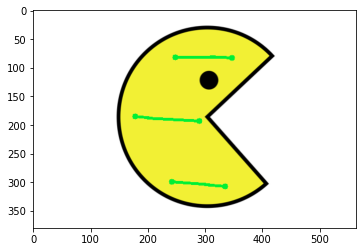

In [42]:
# create a mask image for drawing (u,v) vectors on top of the second frame
mask: np.ndarray = np.zeros_like(frame_2)

# draw the lines between the matching points (these lines indicate motion vectors)
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel().astype(np.int32)
    c,d = old.ravel().astype(np.int32)
    # draw points on the mask image
    mask = cv2.circle(mask,(a,b),5,(200),-1)
    # draw motion vector as lines on the mask image
    mask = cv2.line(mask, (a,b),(c,d), (200), 3)
    # add the line image and second frame together

composite_im: np.ndarray = np.copy(frame_2)
composite_im[mask!=0] = [0]

plt.imshow(composite_im);

### TODO: Perform Optical Flow between image frames 2 and 3

Repeat this process but for the last two image frames; see what the resulting motion vectors look like. Imagine doing this for a series of image frames and plotting the entire-motion-path of a given object.


In [34]:
## TODO: Perform optical flow between image frames 2 and 3
